In [1]:
import cv2

image_shape = (32, 32, 3)

def prepare_image(image_set):
    """Transform initial set of images so that they are ready to be fed to neural network.
    
    (1) normalize image
    (2) convert RGB image to gray scale
    """
    # initialize empty image set for prepared images
    new_shape = image_shape[0:2] + (1,)
    
    prep_image_set = np.empty(shape=(len(image_set),) + new_shape, dtype=int)
    
    for ind in range(0, len(image_set)):
        # normalize
        norm_img = cv2.normalize(image_set[ind], np.zeros(image_shape[0:2]), 0, 255, cv2.NORM_MINMAX)
        
        # grayscale
        gray_img = cv2.cvtColor(norm_img, cv2.COLOR_RGB2GRAY)
        
        # set new image to the corresponding position
        prep_image_set[ind] = np.reshape(gray_img, new_shape)
        
    return prep_image_set
        
def equalize_number_of_samples(image_set, image_labels):
    """Make number of samples in each category equal.
    
    The data set has different number of samples for each category.
    This function will transform the data set in a way that each category 
    will contain the number of samples equal to maximum samples per category
    from the initial set. This will provide an equal probability to meet 
    traffic sign of each category during the training process.
    """
    num = max([len(np.where(image_labels==cat_id)[0]) for cat_id in signNames.keys()])
    
    equalized_image_set = np.empty(shape=(num * n_classes,) + image_set.shape[1:], dtype=int)
    equalized_image_labels = np.empty(shape=(num * n_classes,), dtype=int)
    j = 0
    
    for cat_id in signNames.keys():
        cat_inds = np.where(y_train==cat_id)[0]
        cat_inds_len = len(cat_inds)
    
        for i in range(0, num):
            equalized_image_set[j] = image_set[cat_inds[i % cat_inds_len]]
            equalized_image_labels[j] = image_labels[cat_inds[i % cat_inds_len]]
            j += 1
    
    # at this stage data is definitely not randomly shuffled, so shuffle it
    return shuffle(equalized_image_set, equalized_image_labels)

In [2]:
signNames = { 
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)', 
    2:'Speed limit (50km/h)', 
    3:'Speed limit (60km/h)', 
    4:'Speed limit (70km/h)', 
    5:'Speed limit (80km/h)', 
    6:'End of speed limit (80km/h)', 
    7:'Speed limit (100km/h)', 
    8:'Speed limit (120km/h)', 
    9:'No passing', 
    10:'No passing veh over 3.5 tons', 
    11:'Right-of-way at intersection', 
    12:'Priority road', 
    13:'Yield', 
    14:'Stop', 
    15:'No vehicles', 
    16:'Veh > 3.5 tons prohibited', 
    17:'No entry', 
    18:'General caution', 
    19:'Dangerous curve left', 
    20:'Dangerous curve right', 
    21:'Double curve', 
    22:'Bumpy road', 
    23:'Slippery road', 
    24:'Road narrows on the right', 
    25:'Road work', 
    26:'Traffic signals', 
    27:'Pedestrians', 
    28:'Children crossing', 
    29:'Bicycles crossing', 
    30:'Beware of ice/snow',
    31:'Wild animals crossing', 
    32:'End speed + passing limits', 
    33:'Turn right ahead', 
    34:'Turn left ahead', 
    35:'Ahead only', 
    36:'Go straight or right', 
    37:'Go straight or left', 
    38:'Keep right', 
    39:'Keep left', 
    40:'Roundabout mandatory', 
    41:'End of no passing', 
    42:'End no passing veh > 3.5 tons'
          }

Stop
(32, 32, 3)


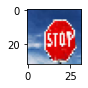

Stop
(32, 32, 3)


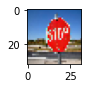

Speed limit (70km/h)
(32, 32, 3)


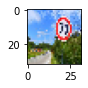

Stop
(32, 32, 3)


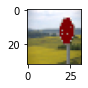

Stop
(32, 32, 3)


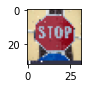

In [3]:
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
NImages = 5
X_real = np.zeros((NImages,32,32,3)).astype(np.uint8)
y_real = np.array([14, 14, 4, 14, 14])
for i in range(NImages):
    image = Image.open('./testImages2/'+str(i+1)+'.jpeg')
    image = image.resize((32, 32))
    image = np.array(image)
    X_real[i] = image
    print(signNames[y_real[i]])
    print(X_real[i].shape)
    plt.figure(figsize=(1,1))
    plt.imshow(X_real[i])
    plt.show()

In [4]:
images_prep = prepare_image(X_real)
labels_prep = y_real

In [6]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()
x = tf.compat.v1.placeholder(tf.float32, shape = (None, 32, 32, 1))
keep_prob = tf.compat.v1.placeholder(tf.float32)

def LeNet(x, keep_prob, channels=1, classes = 43, mu=0, sigma=0.01):
    
    # Layer 1: Convolutional. Input = 32x32xchannels. Output = 28x28x6.
    conv1_W = tf.Variable(tf.compat.v1.truncated_normal(shape=(5, 5, channels, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Layer 1: Activation.
    conv1 = tf.nn.relu(conv1)

    # Layer 1: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.compat.v1.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Layer 2: Activation.
    conv2 = tf.nn.relu(conv2)

    # Layer 2: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Flatten. Input = 5x5x16. Output = 400.
    fc0   = tf.compat.v1.layers.flatten(conv2)
    fc0   = tf.nn.dropout(fc0, rate = 1 - keep_prob)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.compat.v1.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Layer 3: Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.compat.v1.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Layer 4: Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.compat.v1.truncated_normal(shape=(84, classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

logits = LeNet(x, keep_prob)

/home/chenging/anaconda3/envs/test_gpu/lib/python3.7/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:329: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '
/home/chenging/anaconda3/envs/test_gpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


INFO:tensorflow:Restoring parameters from ./model_data/Lenet.ckpt
---------------------------------------------------------------------------------------------
|                  PREDICTED                  |                   ACTUAL                    |
---------------------------------------------------------------------------------------------
| 42      End no passing veh > 3.5 tons       | 14                   Stop                   |
| 42      End no passing veh > 3.5 tons       | 14                   Stop                   |
| 42      End no passing veh > 3.5 tons       | 4            Speed limit (70km/h)           |
| 42      End no passing veh > 3.5 tons       | 14                   Stop                   |
| 42      End no passing veh > 3.5 tons       | 14                   Stop                   |
---------------------------------------------------------------------------------------------


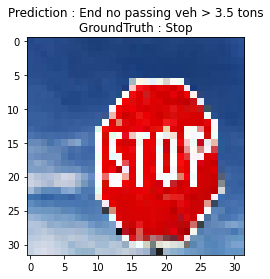

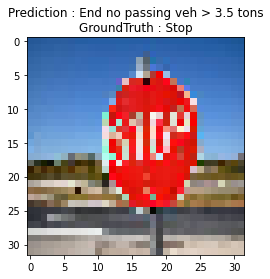

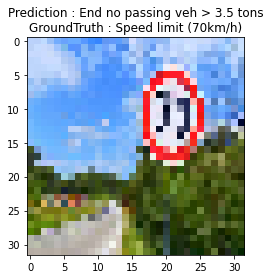

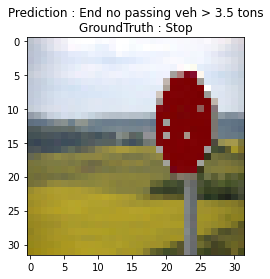

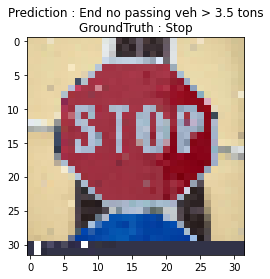

In [8]:
with tf.compat.v1.Session() as sess:
    new_saver = tf.compat.v1.train.import_meta_graph('./model_data/Lenet.ckpt.meta') #載入網路結構
    new_saver.restore(sess, tf.train.latest_checkpoint('./model_data')) #載入最近一次儲存的ckpt
    graph = tf.compat.v1.get_default_graph()  
    #初始化引數
    sess.run(tf.compat.v1.global_variables_initializer())
    sign_ids = sess.run(tf.argmax(logits, 1), feed_dict={x: images_prep, keep_prob: 1})
    
    
# output the results in the table
print('-' * 93)
print("| {p:^43} | {a:^43} |".format(p='PREDICTED', a='ACTUAL'))
print('-' * 93)
for i in range(len(sign_ids)):
    print('| {p:^2} {strp:^40} | {a:^2} {stra:^40} |'.format(
        p=sign_ids[i], strp=signNames[sign_ids[i]], a=y_real[i], stra=signNames[y_real[i]]))
print('-' * 93)

for i in range(len(sign_ids)):
    plt.imshow(X_real[i])
    plt.title('Prediction : ' + signNames[sign_ids[i]] + '\nGroundTruth : ' + signNames[y_real[i]])
    plt.show()